# Script for adding processes and flows in OpenLCA with olca


In [1]:
from IPython.display import IFrame
IFrame('https://nexus.openlca.org/database/ELCD', width=950, height=500)

In [44]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
import olca
import uuid
import math
from datetime import datetime
from itertools import chain

from matplotlib import pyplot as plt

params = {'mathtext.default': 'regular' }

client = olca.Client(8080)
client

<AxesSubplot:xlabel='MRR [mm³/s]'>

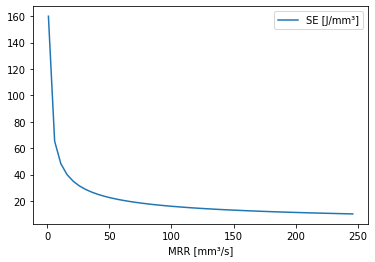

In [45]:
MRR_list = list(range(1, 251, 5))
SE_list = [160 * element**(-0.5) for element in MRR_list]

df_MRR = pd.DataFrame({'MRR [mm³/s]': MRR_list, 'SE [J/mm³]': SE_list })

df_MRR.plot(x='MRR [mm³/s]', y='SE [J/mm³]') 

In [46]:
df_process_char = pd.DataFrame({'in/out': ['in', 'in', 'out', 'out'],
                                'flow': ['Steel sections', 'Electricity', 'Steel scrap', 'machined steel section'],
                                'amount':[1, '8*MRR^(-0.5)', 0.3935, 0.6065],
                                'unit': ['kg', 'MJ', 'kg', 'kg'],
                                'ref flow': [False, False, False, True],
                                'provider': ['09d61948-238a-40e7-8e1f-afdc0c98f902', '7e00d0fc-473a-4c90-89e5-0a586010bf31', '11f67def-dc2a-4e74-bb4f-885610a9ae9c', '']
                               })
df_process_char 

,in/out,flow,amount,unit,ref flow,provider
0,in,Steel sections,1,kg,False,09d61948-238a-40e7-8e1f-afdc0c98f902
1,in,Electricity,8*MRR^(-0.5),MJ,False,7e00d0fc-473a-4c90-89e5-0a586010bf31
2,out,Steel scrap,0.3935,kg,False,11f67def-dc2a-4e74-bb4f-885610a9ae9c
3,out,machined steel section,0.6065,kg,True,


In [47]:
dt_object = datetime.fromtimestamp(datetime.timestamp(datetime.now()))


mass = client.find(olca.FlowProperty, 'Mass')

new_flow = olca.product_flow_of('machined steel section', mass)
new_flow.description = 'Added via olca-ipc on %s.' % (dt_object)
client.insert(new_flow) 

'ok'

In [48]:
dt_object = datetime.fromtimestamp(datetime.timestamp(datetime.now()))

new_process = olca.process_of('Machining steel sections, removing 50 cm³ (parametrized)')
new_process.description = 'Added via olca-ipc on %s.' % (dt_object)
client.insert(new_process)

'ok'

In [49]:
#finding the flow ids, also for the newly created flow ...

target_refs = []

for index, row in df_process_char.iterrows():
    all_obj = client.get_descriptors(olca.Flow)
    cache = [obj for obj in all_obj if df_process_char['flow'][index] == obj.name]
    target_refs.append(cache)
target_refs = list(chain(*target_refs))    #de-nesting list

target_names = [obj.name for obj in target_refs]
target_ids = [obj.id for obj in target_refs]

flow_df = pd.DataFrame(list(zip(target_names, target_ids)), columns = ['name', 'id'])
#flow_df

#adding flow ids to the original table

df_process_char = pd.concat([df_process_char , flow_df['id']], axis=1)
df_process_char = df_process_char[['in/out', 'flow', 'amount', 'unit', 'ref flow', 'id', 'provider']]
df_process_char = df_process_char.fillna('')
#df_process_char.dropna(axis=1,thresh=4, inplace=True)
df_process_char

,in/out,flow,amount,unit,ref flow,id,provider
0,in,Steel sections,1,kg,False,4b51abed-8b83-4135-820c-d421463d80cf,09d61948-238a-40e7-8e1f-afdc0c98f902
1,in,Electricity,8*MRR^(-0.5),MJ,False,f9d24380-e9fa-41d8-a428-efce2dfe313e,7e00d0fc-473a-4c90-89e5-0a586010bf31
2,out,Steel scrap,0.3935,kg,False,5102d55f-e091-4c7d-b3c7-bf26cfb1097e,11f67def-dc2a-4e74-bb4f-885610a9ae9c
3,out,machined steel section,0.6065,kg,True,cefd41bb-5ed0-4558-b240-828e202c8d66,


In [50]:
#creating a list of exchange objects

list_exchanges = []

for index, row in df_process_char.iterrows():
    cache = client.get(olca.Flow, row['id'])
    
    if row['in/out'] == 'in':
        new_exchange = olca.input_of(new_process, cache, row['amount'])
    elif row['in/out'] == 'out':
        new_exchange = olca.output_of(new_process, cache, row['amount'])
    
    if row['ref flow'] == True:
        new_exchange.quantitative_reference = True
    elif row['ref flow'] == False:
        new_exchange.default_provider = client.get(olca.Process, row['provider'])
        
    list_exchanges.append(new_exchange)

list_exchanges

ERROR:root:failed to get entity of type <class 'olca.schema.Process'>: 404: Not found
ERROR:root:failed to get entity of type <class 'olca.schema.Process'>: 404: Not found
ERROR:root:failed to get entity of type <class 'olca.schema.Process'>: 404: Not found


[Exchange(id='', olca_type='Exchange', avoided_product=None, cost_formula=None, cost_value=None, currency=None, internal_id=1, flow=Ref(id='4b51abed-8b83-4135-820c-d421463d80cf', olca_type='Flow', name='machined steel section', description=None, version=None, last_change=None, category_path=None, library=None, ref_unit=None, location=None, flow_type=None, process_type=None), flow_property=None, input=True, quantitative_reference=None, base_uncertainty=None, default_provider=None, amount=1, amount_formula=None, unit=None, dq_entry=None, uncertainty=None, description=None),
 Exchange(id='', olca_type='Exchange', avoided_product=None, cost_formula=None, cost_value=None, currency=None, internal_id=2, flow=Ref(id='f9d24380-e9fa-41d8-a428-efce2dfe313e', olca_type='Flow', name='machined steel section', description=None, version=None, last_change=None, category_path=None, library=None, ref_unit=None, location=None, flow_type=None, process_type=None), flow_property=None, input=True, quantitativ